In [1]:
!pip uninstall -y opencv-python --quiet
!pip install "opencv-python-headless<4.3" --quiet
!pip install -U "tensorflow-text==2.9.*" --quiet
!pip install tf-models-official --quiet
!pip install keras-metrics --quiet
!pip install gensim==3.8.3 --quiet
!pip install pydot --quiet
!pip install sentencepiece --quiet
!pip install transformers --quiet

     |████████████████████████████████| 21.6 MB 4.9 MB/s 
     |████████████████████████████████| 4.6 MB 5.1 MB/s 
     |████████████████████████████████| 511.7 MB 4.9 kB/s 
     |████████████████████████████████| 438 kB 88.4 MB/s 
     |████████████████████████████████| 1.6 MB 62.5 MB/s 
     |████████████████████████████████| 5.8 MB 88.6 MB/s 
     |████████████████████████████████| 2.1 MB 5.0 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 56.2 MB/s 
     |████████████████████████████████| 1.2 MB 68.6 MB/s 
     |████████████████████████████████| 116 kB 94.9 MB/s 
     |████████████████████████████████| 636 kB 72.6 MB/s 
     |████████████████████████████████| 352 kB 80.9 MB/s 
     |████████████████████████████████| 99 kB 12.3 MB/s 
     |████████████████████████████████| 238 kB 93.6 MB/s 
     |████████████████████████████████| 24.2 MB 5.1 MB/s 
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |█████████████

In [2]:
from google.cloud import storage
import google.oauth2.credentials
import json
import seaborn as sns

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
import tensorflow_models as tfm

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
#from keras.preprocessing.sequence import pad_sequences
import torch

import sklearn as sk
import nltk
from nltk.corpus import reuters
from nltk.data import find

import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

from transformers import BertTokenizer, TFBertModel, XLNetTokenizer, TFXLNetForSequenceClassification, TFBertForSequenceClassification, TFRobertaForSequenceClassification, RobertaTokenizer


from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split



## Data loading

In [3]:
# Access drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_test.csv")
valid = pd.read_csv("/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_valid.csv")

In [5]:
x_train = list(train[['text']].text)
y_train = np.asarray(train[['label']].label)

x_test = list(test[['text']].text)
y_test = np.asarray(test[['label']].label)

x_valid = list(valid[['text']].text)
y_valid = np.asarray(valid[['label']].label)

## Roberta

In [6]:
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [7]:
def create_roberta_model(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)):
    """Create a roBERTa model based on the roBERTa paper:
    https://arxiv.org/pdf/1907.11692.pdf 

        - model: TFRobertaForSequenceClassification
    """
    roberta_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

    # Freeze all layers except the last 4 which are the pooled classification layers:
    untrainable = [w.name for w in roberta_model.weights[:-4]]
    trainable = [w.name for w in roberta_model.weights[-4:]]

    for w in roberta_model.weights:
        if w.name in untrainable:
            w._trainable = False
        elif w.name in trainable:
            w._trainable = True

    # Compile the model:
    roberta_model.compile(
        optimizer = optimizer,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy("accuracy")]
    )

    return roberta_model

In [8]:
def tokenize(length, data, tokenizer):
  """Tokenize text using specified tokenizer with the constraint of max_length
    - length: max length of tokenized output
    - data: text to tokenize
    - tokenizer
  """
  encodings = tokenizer(data, 
                max_length=length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')
  return encodings

def run_roberta(length, tokenizer, model_name, x_train, y_train, x_valid, y_valid, x_test, y_test, optimizer=None):
  """ Tokenizes, trains and evaluates roBERTa models for different max_lengths
  """
  print(f"This model will be saved as {model_name}")
  print(f'Running roBERTa for encoding max_length: {length}')
  print('Tokenizing data...')
  train_encodings_roberta = tokenize(length, x_train, tokenizer)
  valid_encodings_roberta = tokenize(length, x_valid, tokenizer)
  test_encodings_roberta = tokenize(length, x_test, tokenizer)

  print(f'Created encoding for training data with shape {train_encodings_roberta.input_ids.shape}')
  print(f'Created encoding for validation data with shape {valid_encodings_roberta.input_ids.shape}')
  print(f'Created encoding for test data with shape {test_encodings_roberta.input_ids.shape}')

  if optimizer:
    print("Using custom optimizer")
    model = create_roberta_model(optimizer=optimizer)
  else:
    model = create_roberta_model()
  print('Training model...')
  history = model.fit(
    [train_encodings_roberta.input_ids, train_encodings_roberta.attention_mask], 
    y_train,
    validation_data=(
        [valid_encodings_roberta.input_ids, valid_encodings_roberta.attention_mask], 
        y_valid
        ),
    batch_size=32, 
    epochs=4
  )

  print('Evaluating model...')
  score = model.evaluate([test_encodings_roberta.input_ids, test_encodings_roberta.attention_mask], y_test)

  print("Test loss:", score[0])
  print("Test accuracy:", score[1])

  predictions = model.predict([test_encodings_roberta.input_ids, test_encodings_roberta.attention_mask])
  preds = predictions.to_tuple()[0].argmax(1)
  print('\n Classification Report:\n')
  print(classification_report(y_test, preds))

  model.save(
    str.format("/content/drive/My Drive/models/Project W266/{name}", name = model_name),
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
  )


### Running for various lengths of embeddings

In [ ]:
max_lengths = [64,128,256,320,384,448,512]
for length in max_lengths:
  run_roberta(length, roberta_tokenizer, str.format('roberta_model_{length}', length = length), 
                                                    x_train = x_train,
                                                    y_train = y_train,
                                                    x_valid = x_valid,
                                                    y_valid = y_valid,
                                                    x_test = x_test,
                                                    y_test = y_test)

Running roBERTa for encoding max_length: 64
Tokenizing data...
Created encoding for training data with shape (47146, 64)
Created encoding for validation data with shape (5893, 64)
Created encoding for test data with shape (5894, 64)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 170s 111ms/step - loss: 0.6682 - accuracy: 0.6166 - val_loss: 0.6404 - val_accuracy: 0.6959
Epoch 2/4
1474/1474 [==============================] - 161s 109ms/step - loss: 0.6302 - accuracy: 0.6747 - val_loss: 0.6023 - val_accuracy: 0.7168
Epoch 3/4
1474/1474 [==============================] - 161s 109ms/step - loss: 0.6068 - accuracy: 0.6947 - val_loss: 0.5813 - val_accuracy: 0.7175
Epoch 4/4
1474/1474 [==============================] - 161s 110ms/step - loss: 0.5971 - accuracy: 0.7027 - val_loss: 0.5661 - val_accuracy: 0.7310
Evaluating model...
185/185 [==============================] - 17s 93ms/step - loss: 0.5791 - accuracy: 0.7128
Test loss: 0.579146146774292
Test accuracy: 0.7127587199211121

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.70      0.71      2992
           1       0.70      0.73      0.71      2902

    accuracy                           0.71      5894
   m

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_64/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_64/assets


Running roBERTa for encoding max_length: 128
Tokenizing data...
Created encoding for training data with shape (47146, 128)
Created encoding for validation data with shape (5893, 128)
Created encoding for test data with shape (5894, 128)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 311s 207ms/step - loss: 0.6516 - accuracy: 0.6479 - val_loss: 0.6158 - val_accuracy: 0.7147
Epoch 2/4
1474/1474 [==============================] - 301s 204ms/step - loss: 0.6063 - accuracy: 0.7033 - val_loss: 0.5769 - val_accuracy: 0.7417
Epoch 3/4
1474/1474 [==============================] - 302s 205ms/step - loss: 0.5807 - accuracy: 0.7279 - val_loss: 0.5515 - val_accuracy: 0.7528
Epoch 4/4
1474/1474 [==============================] - 302s 205ms/step - loss: 0.5669 - accuracy: 0.7367 - val_loss: 0.5378 - val_accuracy: 0.7545
Evaluating model...
185/185 [==============================] - 32s 171ms/step - loss: 0.5464 - accuracy: 0.7465
Test loss: 0.5463767051696777
Test accuracy: 0.7465218901634216

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.80      0.76      2992
           1       0.77      0.70      0.73      2902

    accuracy                           0.75      5894
  

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_128/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_128/assets


Running roBERTa for encoding max_length: 256
Tokenizing data...
Created encoding for training data with shape (47146, 256)
Created encoding for validation data with shape (5893, 256)
Created encoding for test data with shape (5894, 256)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 616s 414ms/step - loss: 0.6490 - accuracy: 0.6703 - val_loss: 0.6157 - val_accuracy: 0.7524
Epoch 2/4
1474/1474 [==============================] - 608s 412ms/step - loss: 0.5963 - accuracy: 0.7340 - val_loss: 0.5648 - val_accuracy: 0.7592
Epoch 3/4
1474/1474 [==============================] - 607s 412ms/step - loss: 0.5658 - accuracy: 0.7466 - val_loss: 0.5341 - val_accuracy: 0.7668
Epoch 4/4
1474/1474 [==============================] - 607s 412ms/step - loss: 0.5511 - accuracy: 0.7503 - val_loss: 0.5157 - val_accuracy: 0.7750
Evaluating model...
185/185 [==============================] - 62s 336ms/step - loss: 0.5287 - accuracy: 0.7677
Test loss: 0.5286672711372375
Test accuracy: 0.7677298784255981

 Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2992
           1       0.76      0.78      0.77      2902

    accuracy                           0.77      5894
  

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_256/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_256/assets


Running roBERTa for encoding max_length: 320
Tokenizing data...
Created encoding for training data with shape (47146, 320)
Created encoding for validation data with shape (5893, 320)
Created encoding for test data with shape (5894, 320)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 791s 533ms/step - loss: 0.6482 - accuracy: 0.6892 - val_loss: 0.6130 - val_accuracy: 0.7582
Epoch 2/4
1474/1474 [==============================] - 782s 531ms/step - loss: 0.5887 - accuracy: 0.7438 - val_loss: 0.5564 - val_accuracy: 0.7651
Epoch 3/4
1474/1474 [==============================] - 782s 531ms/step - loss: 0.5604 - accuracy: 0.7532 - val_loss: 0.5269 - val_accuracy: 0.7736
Epoch 4/4
1474/1474 [==============================] - 782s 531ms/step - loss: 0.5427 - accuracy: 0.7554 - val_loss: 0.5102 - val_accuracy: 0.7724
Evaluating model...
185/185 [==============================] - 79s 430ms/step - loss: 0.5212 - accuracy: 0.7703
Test loss: 0.5211576223373413
Test accuracy: 0.7702748775482178

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.79      0.78      2992
           1       0.78      0.75      0.76      2902

    accuracy                           0.77      5894
  

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_320/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_320/assets


Running roBERTa for encoding max_length: 384
Tokenizing data...
Created encoding for training data with shape (47146, 384)
Created encoding for validation data with shape (5893, 384)
Created encoding for test data with shape (5894, 384)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 982s 663ms/step - loss: 0.6472 - accuracy: 0.6916 - val_loss: 0.6131 - val_accuracy: 0.7612
Epoch 2/4
1474/1474 [==============================] - 975s 662ms/step - loss: 0.5905 - accuracy: 0.7461 - val_loss: 0.5576 - val_accuracy: 0.7684
Epoch 3/4
1474/1474 [==============================] - 975s 662ms/step - loss: 0.5599 - accuracy: 0.7529 - val_loss: 0.5266 - val_accuracy: 0.7719
Epoch 4/4
1474/1474 [==============================] - 976s 662ms/step - loss: 0.5438 - accuracy: 0.7550 - val_loss: 0.5101 - val_accuracy: 0.7746
Evaluating model...
185/185 [==============================] - 99s 532ms/step - loss: 0.5214 - accuracy: 0.7715
Test loss: 0.521388590335846
Test accuracy: 0.7714625000953674

 Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      2992
           1       0.77      0.76      0.77      2902

    accuracy                           0.77      5894
   

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_384/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_384/assets


Running roBERTa for encoding max_length: 448
Tokenizing data...
Created encoding for training data with shape (47146, 448)
Created encoding for validation data with shape (5893, 448)
Created encoding for test data with shape (5894, 448)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 1163s 785ms/step - loss: 0.6457 - accuracy: 0.6958 - val_loss: 0.6102 - val_accuracy: 0.7629
Epoch 2/4
1474/1474 [==============================] - 1155s 784ms/step - loss: 0.5877 - accuracy: 0.7482 - val_loss: 0.5546 - val_accuracy: 0.7679
Epoch 3/4
1474/1474 [==============================] - 1155s 784ms/step - loss: 0.5556 - accuracy: 0.7557 - val_loss: 0.5229 - val_accuracy: 0.7733
Epoch 4/4
1474/1474 [==============================] - 1154s 783ms/step - loss: 0.5434 - accuracy: 0.7557 - val_loss: 0.5081 - val_accuracy: 0.7752
Evaluating model...
185/185 [==============================] - 115s 622ms/step - loss: 0.5193 - accuracy: 0.7706
Test loss: 0.5192633867263794
Test accuracy: 0.7706142067909241

 Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2992
           1       0.77      0.75      0.76      2902

    accuracy                           0.77      58

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_448/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_448/assets


Running roBERTa for encoding max_length: 512
Tokenizing data...
Created encoding for training data with shape (47146, 512)
Created encoding for validation data with shape (5893, 512)
Created encoding for test data with shape (5894, 512)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 1383s 935ms/step - loss: 0.6452 - accuracy: 0.6976 - val_loss: 0.6134 - val_accuracy: 0.7256
Epoch 2/4
1474/1474 [==============================] - 1375s 933ms/step - loss: 0.5870 - accuracy: 0.7472 - val_loss: 0.5538 - val_accuracy: 0.7645
Epoch 3/4
1474/1474 [==============================] - 1375s 933ms/step - loss: 0.5583 - accuracy: 0.7512 - val_loss: 0.5237 - val_accuracy: 0.7719
Epoch 4/4
1474/1474 [==============================] - 1375s 933ms/step - loss: 0.5403 - accuracy: 0.7590 - val_loss: 0.5072 - val_accuracy: 0.7728
Evaluating model...
185/185 [==============================] - 136s 735ms/step - loss: 0.5183 - accuracy: 0.7710
Test loss: 0.5182607769966125
Test accuracy: 0.7709535360336304

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      2992
           1       0.79      0.73      0.76      2902

    accuracy                           0.77      58

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_512/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_512/assets


### Trying out a linear decay learning rate

In [9]:
def create_learning_schedule(initial_learning_rate=2e-5):
  # Set up epochs and steps
  epochs = 4
  batch_size = 32

  train_data_size = len(x_train)
  steps_per_epoch = int(train_data_size / batch_size)
  num_train_steps = steps_per_epoch * epochs
  # Using 6% of the data for warm up as this is what was done in the roBERTa paper
  warmup_steps = int(0.06 * num_train_steps)

  linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=initial_learning_rate,
      end_learning_rate=0,
      decay_steps=num_train_steps)

  warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
      warmup_learning_rate = 0,
      after_warmup_lr_sched = linear_decay,
      warmup_steps = warmup_steps
  )
  return warmup_schedule


In [ ]:
# Try it on our our previous best max_length of 384
max_lengths = [384]
# Learning rates from RoBERTa paper:
learning_rates = [1e-5, 2e-5, 3e-5]
for initial_learning_rate in learning_rates:
  warmup_schedule = create_learning_schedule(initial_learning_rate)
  for length in max_lengths:
    model_name = str.format('roberta_model_{length}_lr-{learning_rate}', length=length, learning_rate=initial_learning_rate)
    run_roberta(length, roberta_tokenizer, model_name, 
                                                    x_train = x_train_bilal,
                                                    y_train = y_train_bilal,
                                                    x_valid = x_valid_bilal,
                                                    y_valid = y_valid_bilal,
                                                    x_test = x_test_bilal,
                                                    y_test = y_test_bilal,
                                                    optimizer = tf.keras.optimizers.experimental.Adam(
      learning_rate = warmup_schedule))

This model will be saved as roberta_model_384_lr-1e-05
Running roBERTa for encoding max_length: 384
Tokenizing data...
Created encoding for training data with shape (47146, 384)
Created encoding for validation data with shape (5893, 384)
Created encoding for test data with shape (5894, 384)
Using custom optimizer


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 929s 626ms/step - loss: 0.6733 - accuracy: 0.6328 - val_loss: 0.6595 - val_accuracy: 0.7534
Epoch 2/4
1474/1474 [==============================] - 920s 624ms/step - loss: 0.6401 - accuracy: 0.7245 - val_loss: 0.6346 - val_accuracy: 0.7567
Epoch 3/4
1474/1474 [==============================] - 920s 624ms/step - loss: 0.6261 - accuracy: 0.7354 - val_loss: 0.6213 - val_accuracy: 0.7616
Epoch 4/4
1474/1474 [==============================] - 920s 624ms/step - loss: 0.6159 - accuracy: 0.7409 - val_loss: 0.6170 - val_accuracy: 0.7614
Evaluating model...
185/185 [==============================] - 92s 497ms/step - loss: 0.6213 - accuracy: 0.7603
Test loss: 0.6212723851203918
Test accuracy: 0.7602646946907043
185/185 [==============================] - 94s 492ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      2992
           1       0.76      0.75      0.75      2902

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_384_lr-1e-05/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_384_lr-1e-05/assets


This model will be saved as roberta_model_384_lr-2e-05
Running roBERTa for encoding max_length: 384
Tokenizing data...
Created encoding for training data with shape (47146, 384)
Created encoding for validation data with shape (5893, 384)
Created encoding for test data with shape (5894, 384)
Using custom optimizer


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 929s 626ms/step - loss: 0.6616 - accuracy: 0.6547 - val_loss: 0.6339 - val_accuracy: 0.7522
Epoch 2/4
1474/1474 [==============================] - 920s 624ms/step - loss: 0.6094 - accuracy: 0.7393 - val_loss: 0.5894 - val_accuracy: 0.7638
Epoch 3/4
1474/1474 [==============================] - 920s 624ms/step - loss: 0.5862 - accuracy: 0.7479 - val_loss: 0.5689 - val_accuracy: 0.7657
Epoch 4/4
1474/1474 [==============================] - 920s 624ms/step - loss: 0.5730 - accuracy: 0.7504 - val_loss: 0.5629 - val_accuracy: 0.7679
Evaluating model...
185/185 [==============================] - 92s 497ms/step - loss: 0.5704 - accuracy: 0.7615
Test loss: 0.5704007148742676
Test accuracy: 0.761452317237854
185/185 [==============================] - 94s 493ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      2992
           1       0.76      0.76      0.76      2902


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_384_lr-2e-05/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_384_lr-2e-05/assets


This model will be saved as roberta_model_384_lr-3e-05
Running roBERTa for encoding max_length: 384
Tokenizing data...
Created encoding for training data with shape (47146, 384)
Created encoding for validation data with shape (5893, 384)
Created encoding for test data with shape (5894, 384)
Using custom optimizer


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 930s 626ms/step - loss: 0.6487 - accuracy: 0.6821 - val_loss: 0.6062 - val_accuracy: 0.7575
Epoch 2/4
1474/1474 [==============================] - 921s 625ms/step - loss: 0.5841 - accuracy: 0.7453 - val_loss: 0.5541 - val_accuracy: 0.7675
Epoch 3/4
1474/1474 [==============================] - 921s 625ms/step - loss: 0.5601 - accuracy: 0.7537 - val_loss: 0.5349 - val_accuracy: 0.7689
Epoch 4/4
1474/1474 [==============================] - 921s 625ms/step - loss: 0.5526 - accuracy: 0.7544 - val_loss: 0.5305 - val_accuracy: 0.7709
Evaluating model...
185/185 [==============================] - 92s 497ms/step - loss: 0.5402 - accuracy: 0.7667
Test loss: 0.5402488708496094
Test accuracy: 0.7667118906974792
185/185 [==============================] - 94s 492ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2992
           1       0.77      0.75      0.76      2902

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_384_lr-3e-05/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_384_lr-3e-05/assets


## Extra-large data set
Trying out the best RoBERTa model on a larger data set (600k) to see if it brings much improvement 

In [ ]:
# Larger data set:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_train_large.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_test_large.csv")
valid = pd.read_csv("/content/drive/My Drive/Colab Notebooks/W266 Project/data/yelp_valid_large.csv")

x_train = list(train[['text']].text)
y_train = np.asarray(train[['label']].label)

x_test = list(test[['text']].text)
y_test = np.asarray(test[['label']].label)

x_valid = list(valid[['text']].text)
y_valid = np.asarray(valid[['label']].label)

len(x_train)

471465

In [ ]:
max_lengths = [384]
for length in max_lengths:
  run_roberta(length, roberta_tokenizer, 'roberta_384_large')

This model will be saved as roberta_384_large
Running roBERTa for encoding max_length: 384
Tokenizing data...
Created encoding for training data with shape (471465, 384)
Created encoding for validation data with shape (58933, 384)
Created encoding for test data with shape (58934, 384)


Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


14734/14734 [==============================] - 9203s 624ms/step - loss: 0.5470 - accuracy: 0.7520 - val_loss: 0.4895 - val_accuracy: 0.7760
Epoch 2/4
14734/14734 [==============================] - 9201s 624ms/step - loss: 0.5098 - accuracy: 0.7652 - val_loss: 0.4803 - val_accuracy: 0.7806
Epoch 3/4
14734/14734 [==============================] - 9202s 625ms/step - loss: 0.5031 - accuracy: 0.7667 - val_loss: 0.4766 - val_accuracy: 0.7807
Epoch 4/4
14734/14734 [==============================] - 9207s 625ms/step - loss: 0.5001 - accuracy: 0.7677 - val_loss: 0.4753 - val_accuracy: 0.7819
Evaluating model...
1842/1842 [==============================] - 921s 500ms/step - loss: 0.4713 - accuracy: 0.7852
Test loss: 0.4712928533554077
Test accuracy: 0.7852004170417786
1842/1842 [==============================] - 915s 495ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.80      0.79     29388
           1       0.79      0.77  

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_384_large/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_384_large/assets


It does make an improvement (0.771 -> 0.785) but the time taken to run it is very long (~10 hours)

## Error analysis
Performing some error analysis on our best model so far (RoBERTa with max_length of 384 and a static learning rate)

In [9]:
# load previous best model to do some error analysis:
saved_model = create_roberta_model()
saved_model.load_weights('/content/drive/My Drive/models/Project W266/roberta_model_384')

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
test_encodings_roberta = tokenize(384, x_test, roberta_tokenizer)

print(f'Created encoding for test data with shape {test_encodings_roberta.input_ids.shape}')

print('Evaluating model...')
score = saved_model.evaluate([test_encodings_roberta.input_ids, test_encodings_roberta.attention_mask], y_test)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

predictions = saved_model.predict([test_encodings_roberta.input_ids, test_encodings_roberta.attention_mask])
preds = predictions.to_tuple()[0].argmax(1)
print('\n Classification Report:\n')
print(classification_report(y_test, preds))

Created encoding for test data with shape (5894, 384)
Evaluating model...
185/185 [==============================] - 98s 496ms/step - loss: 0.5705 - accuracy: 0.7613
Test loss: 0.5705196261405945
Test accuracy: 0.7612826824188232
185/185 [==============================] - 94s 492ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2992
           1       0.75      0.77      0.76      2902

    accuracy                           0.76      5894
   macro avg       0.76      0.76      0.76      5894
weighted avg       0.76      0.76      0.76      5894



In [41]:
test_results = pd.DataFrame({'text': x_test, 'label': y_test, 'pred': preds})
test_results['text_length'] = [len(t) for t in test_results.text]
TP = test_results[(test_results.label == 1) & (test_results.pred == 1)]
FP = test_results[(test_results.label == 0) & (test_results.pred == 1)]
TN = test_results[(test_results.label == 0) & (test_results.pred == 0)]
FN = test_results[(test_results.label == 1) & (test_results.pred == 0)]

print(f'TP size: {TP.shape[0]}')
print(f'FP size: {FP.shape[0]}')
print(f'TN size: {TN.shape[0]}')
print(f'FN size: {FN.shape[0]}')

TP size: 2240
FP size: 745
TN size: 2247
FN size: 662


In [44]:
print(f'Average review length for TP: {round(TP.text_length.mean(), 1)}')
print(f'Average review length for FP: {round(FP.text_length.mean(), 1)}')
print(f'Average review length for TN: {round(TN.text_length.mean(), 1)}')
print(f'Average review length for FN: {round(FN.text_length.mean(), 1)}')

Average review length for TP: 1286.2
Average review length for FP: 881.8
Average review length for TN: 284.4
Average review length for FN: 407.3


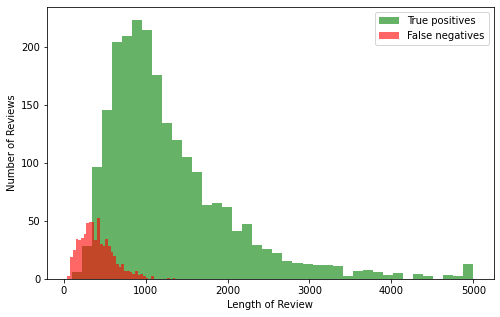

In [70]:
fig, ax = plt.subplots(figsize=(8, 5));
ax.hist(TP.text_length, bins=40, color='g', alpha=0.6, label="True positives")
ax.hist(FN.text_length, bins=40, color='r', alpha=0.6, label="False negatives")
ax.set_xlabel("Length of Review")
ax.set_ylabel("Number of Reviews")
plt.legend()
plt.show()

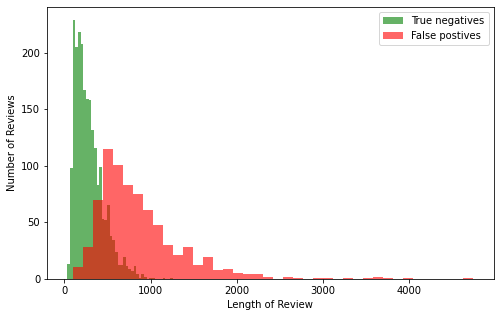

In [71]:
fig, ax = plt.subplots(figsize=(8, 5));
ax.hist(TN.text_length, bins=40, color='g', alpha=0.6, label="True negatives")
ax.hist(FP.text_length, bins=40, color='r', alpha=0.6, label="False postives")
ax.set_xlabel("Length of Review")
ax.set_ylabel("Number of Reviews")
plt.legend()
plt.show()

From this we can see that the model is incorrectly classifying shorter reviews as negative, and incorrectly classifying a lot of longer reviews as positive.

We could try clipping the original review text before embedding to see if this helps

In [76]:
print(f'Average length of review in the training data: {round(sum([len(x) for x in x_train]) / len(x_train), 1)}')

Average length of review in the training data: 761.7


In [85]:
train_df = pd.DataFrame({'text': x_train, 'label': y_train})
train_df['length'] = [len(t) for t in train_df.text]
print(f'Average length of negative class reviews: {round(sum(train_df[train_df.label == 0].length) / len(train_df[train_df.label == 0]),1)}')
print(f'Average length of postive class reviews: {round(sum(train_df[train_df.label == 1].length) / len(train_df[train_df.label == 1]),1)}')

Average length of negative class reviews: 428.7
Average length of postive class reviews: 1091.4


In [87]:
# Trim all reviews to first 500 characters
x_train_trimmed = [x[0:500] for x in x_train]
sum([len(x) for x in x_train_trimmed]) / len(x_train_trimmed)

391.8607729181691

In [88]:
# Do the same for text and validation
x_valid_trimmed = [x[0:500] for x in x_valid]
x_test_trimmed = [x[0:500] for x in x_test]

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    print(f"Average review embedding length: {sum(tokenized_texts_len)/len(tokenized_texts_len)}")
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Review Embeddings");
    ax.set_ylabel("Number of Reviews");
    return

Average review embedding length: 91.78568701480508


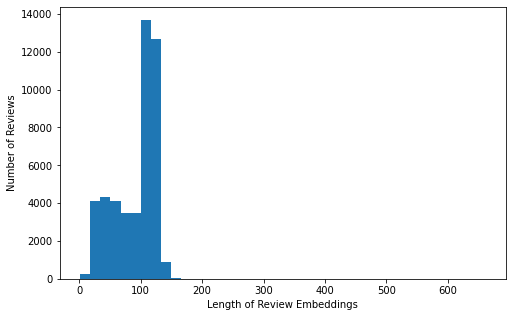

In [90]:
# Now check what the distribution of embedding length looks like before choosing a max length param:
plot_sentence_embeddings_length(x_train_trimmed, roberta_tokenizer)

In [98]:
# Now try with an embedding size of 64, 128, 192 
max_lengths = [64,128,192]
for length in max_lengths:
  run_roberta(length, roberta_tokenizer, str.format('roberta_model_500_trimmed_{length}', length = length), 
                                                    x_train = x_train_trimmed,
                                                    y_train = y_train,
                                                    x_valid = x_valid_trimmed,
                                                    y_valid = y_valid,
                                                    x_test = x_test_trimmed,
                                                    y_test = y_test)

This model will be saved as roberta_model_500_trimmed_64
Running roBERTa for encoding max_length: 64
Tokenizing data...
Created encoding for training data with shape (47146, 64)
Created encoding for validation data with shape (5893, 64)
Created encoding for test data with shape (5894, 64)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 162s 107ms/step - loss: 0.6673 - accuracy: 0.6195 - val_loss: 0.6405 - val_accuracy: 0.6671
Epoch 2/4
1474/1474 [==============================] - 154s 104ms/step - loss: 0.6270 - accuracy: 0.6785 - val_loss: 0.6000 - val_accuracy: 0.7209
Epoch 3/4
1474/1474 [==============================] - 154s 104ms/step - loss: 0.6084 - accuracy: 0.6943 - val_loss: 0.5796 - val_accuracy: 0.7231
Epoch 4/4
1474/1474 [==============================] - 154s 104ms/step - loss: 0.5964 - accuracy: 0.7026 - val_loss: 0.5660 - val_accuracy: 0.7329
Evaluating model...
185/185 [==============================] - 16s 88ms/step - loss: 0.5790 - accuracy: 0.7126
Test loss: 0.578998327255249
Test accuracy: 0.7125890851020813
185/185 [==============================] - 19s 86ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.70      0.71      2992
           1       0.70      0.73      0.71      2902

 

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_64/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_64/assets


This model will be saved as roberta_model_500_trimmed_128
Running roBERTa for encoding max_length: 128
Tokenizing data...
Created encoding for training data with shape (47146, 128)
Created encoding for validation data with shape (5893, 128)
Created encoding for test data with shape (5894, 128)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 296s 197ms/step - loss: 0.6277 - accuracy: 0.6809 - val_loss: 0.5895 - val_accuracy: 0.7349
Epoch 2/4
1474/1474 [==============================] - 288s 196ms/step - loss: 0.5846 - accuracy: 0.7258 - val_loss: 0.5603 - val_accuracy: 0.7433
Epoch 3/4
1474/1474 [==============================] - 287s 195ms/step - loss: 0.5693 - accuracy: 0.7349 - val_loss: 0.5434 - val_accuracy: 0.7473
Epoch 4/4
1474/1474 [==============================] - 287s 195ms/step - loss: 0.5605 - accuracy: 0.7401 - val_loss: 0.5353 - val_accuracy: 0.7478
Evaluating model...
185/185 [==============================] - 30s 162ms/step - loss: 0.5441 - accuracy: 0.7396
Test loss: 0.5440837144851685
Test accuracy: 0.7395656704902649
185/185 [==============================] - 32s 159ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.79      0.76      2992
           1       0.76      0.68      0.72      2902

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_128/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_128/assets


This model will be saved as roberta_model_500_trimmed_192
Running roBERTa for encoding max_length: 192
Tokenizing data...
Created encoding for training data with shape (47146, 192)
Created encoding for validation data with shape (5893, 192)
Created encoding for test data with shape (5894, 192)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 443s 297ms/step - loss: 0.6231 - accuracy: 0.6854 - val_loss: 0.5866 - val_accuracy: 0.7356
Epoch 2/4
1474/1474 [==============================] - 435s 295ms/step - loss: 0.5829 - accuracy: 0.7284 - val_loss: 0.5555 - val_accuracy: 0.7478
Epoch 3/4
1474/1474 [==============================] - 435s 295ms/step - loss: 0.5662 - accuracy: 0.7370 - val_loss: 0.5387 - val_accuracy: 0.7539
Epoch 4/4
1474/1474 [==============================] - 435s 295ms/step - loss: 0.5585 - accuracy: 0.7416 - val_loss: 0.5296 - val_accuracy: 0.7573
Evaluating model...
185/185 [==============================] - 45s 243ms/step - loss: 0.5404 - accuracy: 0.7508
Test loss: 0.540351152420044
Test accuracy: 0.750763475894928
185/185 [==============================] - 47s 239ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      2992
           1       0.74      0.76      0.75      2902



INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_192/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_192/assets


In [9]:
# Try selecting the middle 500 characters instead:
import math 

def select_middle(data, text_length = 500):
  trimmed_data = []
  for item in data:
    middle_index = math.floor(len(item) / 2)
    if len(item) > text_length:
      lower_bound = middle_index - math.floor(text_length / 2)
      upper_bound = middle_index + math.floor(text_length / 2)
      trimmed_data.append(item[lower_bound:upper_bound])
    else: 
      trimmed_data.append(item)
  return trimmed_data

In [10]:
x_train_trimmed_middle = select_middle(x_train, 300)
x_valid_trimmed_middle = select_middle(x_valid, 300)
x_test_trimmed_middle = select_middle(x_test, 300)

In [11]:
# Select middle 300:
# Now try with an embedding size of 64, 128, 192 
max_lengths = [64,128,192]
for length in max_lengths:
  run_roberta(length, roberta_tokenizer, str.format('roberta_model_300_trimmed_middle_{length}', length = length), 
                                                    x_train = x_train_trimmed_middle,
                                                    y_train = y_train,
                                                    x_valid = x_valid_trimmed_middle,
                                                    y_valid = y_valid,
                                                    x_test = x_test_trimmed_middle,
                                                    y_test = y_test)

This model will be saved as roberta_model_500_trimmed_middle_64
Running roBERTa for encoding max_length: 64
Tokenizing data...
Created encoding for training data with shape (47146, 64)
Created encoding for validation data with shape (5893, 64)
Created encoding for test data with shape (5894, 64)


Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 232s 150ms/step - loss: 0.6649 - accuracy: 0.6199 - val_loss: 0.6385 - val_accuracy: 0.6698
Epoch 2/4
1474/1474 [==============================] - 214s 145ms/step - loss: 0.6325 - accuracy: 0.6632 - val_loss: 0.6125 - val_accuracy: 0.6817
Epoch 3/4
1474/1474 [==============================] - 216s 147ms/step - loss: 0.6149 - accuracy: 0.6847 - val_loss: 0.5926 - val_accuracy: 0.7086
Epoch 4/4
1474/1474 [==============================] - 215s 146ms/step - loss: 0.6069 - accuracy: 0.6906 - val_loss: 0.5836 - val_accuracy: 0.7130
Evaluating model...
185/185 [==============================] - 24s 127ms/step - loss: 0.5946 - accuracy: 0.6992
Test loss: 0.5945922136306763
Test accuracy: 0.6991856098175049
185/185 [==============================] - 26s 120ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.70      0.70      2992
           1       0.69      0.70      0.70      2902

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_64/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_64/assets


This model will be saved as roberta_model_500_trimmed_middle_128
Running roBERTa for encoding max_length: 128
Tokenizing data...
Created encoding for training data with shape (47146, 128)
Created encoding for validation data with shape (5893, 128)
Created encoding for test data with shape (5894, 128)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 371s 246ms/step - loss: 0.6390 - accuracy: 0.6591 - val_loss: 0.6084 - val_accuracy: 0.6952
Epoch 2/4
1474/1474 [==============================] - 359s 244ms/step - loss: 0.6077 - accuracy: 0.6954 - val_loss: 0.5854 - val_accuracy: 0.7098
Epoch 3/4
1474/1474 [==============================] - 359s 243ms/step - loss: 0.5978 - accuracy: 0.7004 - val_loss: 0.5748 - val_accuracy: 0.7144
Epoch 4/4
1474/1474 [==============================] - 359s 244ms/step - loss: 0.5938 - accuracy: 0.7041 - val_loss: 0.5687 - val_accuracy: 0.7180
Evaluating model...
185/185 [==============================] - 38s 203ms/step - loss: 0.5786 - accuracy: 0.7148
Test loss: 0.5785771012306213
Test accuracy: 0.7147946953773499
185/185 [==============================] - 41s 199ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2992
           1       0.71      0.71      0.71      2902

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_128/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_128/assets


This model will be saved as roberta_model_500_trimmed_middle_192
Running roBERTa for encoding max_length: 192
Tokenizing data...
Created encoding for training data with shape (47146, 192)
Created encoding for validation data with shape (5893, 192)
Created encoding for test data with shape (5894, 192)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 533s 356ms/step - loss: 0.6385 - accuracy: 0.6627 - val_loss: 0.6068 - val_accuracy: 0.6978
Epoch 2/4
1474/1474 [==============================] - 519s 352ms/step - loss: 0.6081 - accuracy: 0.6936 - val_loss: 0.5859 - val_accuracy: 0.7059
Epoch 3/4
1474/1474 [==============================] - 519s 352ms/step - loss: 0.5991 - accuracy: 0.7001 - val_loss: 0.5752 - val_accuracy: 0.7151
Epoch 4/4
1474/1474 [==============================] - 518s 352ms/step - loss: 0.5934 - accuracy: 0.7056 - val_loss: 0.5683 - val_accuracy: 0.7180
Evaluating model...
185/185 [==============================] - 54s 291ms/step - loss: 0.5784 - accuracy: 0.7139
Test loss: 0.5783989429473877
Test accuracy: 0.7139464020729065
185/185 [==============================] - 57s 287ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2992
           1       0.71      0.70      0.71      2902

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_192/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_192/assets


In [103]:
# Now try with an embedding size of 64, 128, 192 
max_lengths = [64,128,192]
for length in max_lengths:
  run_roberta(length, roberta_tokenizer, str.format('roberta_model_500_trimmed_middle_{length}', length = length), 
                                                    x_train = x_train_trimmed_middle,
                                                    y_train = y_train,
                                                    x_valid = x_valid_trimmed_middle,
                                                    y_valid = y_valid,
                                                    x_test = x_test_trimmed_middle,
                                                    y_test = y_test)

This model will be saved as roberta_model_500_trimmed_middle_64
Running roBERTa for encoding max_length: 64
Tokenizing data...
Created encoding for training data with shape (47146, 64)
Created encoding for validation data with shape (5893, 64)
Created encoding for test data with shape (5894, 64)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 162s 106ms/step - loss: 0.6457 - accuracy: 0.6470 - val_loss: 0.6151 - val_accuracy: 0.6895
Epoch 2/4
1474/1474 [==============================] - 154s 104ms/step - loss: 0.6150 - accuracy: 0.6864 - val_loss: 0.5902 - val_accuracy: 0.7136
Epoch 3/4
1474/1474 [==============================] - 154s 105ms/step - loss: 0.6046 - accuracy: 0.6961 - val_loss: 0.5786 - val_accuracy: 0.7200
Epoch 4/4
1474/1474 [==============================] - 154s 104ms/step - loss: 0.5991 - accuracy: 0.6996 - val_loss: 0.5718 - val_accuracy: 0.7220
Evaluating model...
185/185 [==============================] - 16s 88ms/step - loss: 0.5843 - accuracy: 0.7104
Test loss: 0.584299623966217
Test accuracy: 0.710383415222168
185/185 [==============================] - 19s 87ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      2992
           1       0.70      0.72      0.71      2902

  

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_64/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_64/assets


This model will be saved as roberta_model_500_trimmed_middle_128
Running roBERTa for encoding max_length: 128
Tokenizing data...
Created encoding for training data with shape (47146, 128)
Created encoding for validation data with shape (5893, 128)
Created encoding for test data with shape (5894, 128)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 295s 197ms/step - loss: 0.6237 - accuracy: 0.6860 - val_loss: 0.5900 - val_accuracy: 0.7246
Epoch 2/4
1474/1474 [==============================] - 287s 195ms/step - loss: 0.5874 - accuracy: 0.7225 - val_loss: 0.5634 - val_accuracy: 0.7483
Epoch 3/4
1474/1474 [==============================] - 287s 195ms/step - loss: 0.5739 - accuracy: 0.7326 - val_loss: 0.5501 - val_accuracy: 0.7519
Epoch 4/4
1474/1474 [==============================] - 287s 195ms/step - loss: 0.5655 - accuracy: 0.7374 - val_loss: 0.5399 - val_accuracy: 0.7577
Evaluating model...
185/185 [==============================] - 30s 162ms/step - loss: 0.5499 - accuracy: 0.7501
Test loss: 0.5498960614204407
Test accuracy: 0.7500848174095154
185/185 [==============================] - 32s 159ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      2992
           1       0.74      0.75      0.75      2902

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_128/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_128/assets


This model will be saved as roberta_model_500_trimmed_middle_192
Running roBERTa for encoding max_length: 192
Tokenizing data...
Created encoding for training data with shape (47146, 192)
Created encoding for validation data with shape (5893, 192)
Created encoding for test data with shape (5894, 192)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


1474/1474 [==============================] - 443s 297ms/step - loss: 0.6198 - accuracy: 0.6919 - val_loss: 0.5868 - val_accuracy: 0.7266
Epoch 2/4
1474/1474 [==============================] - 435s 295ms/step - loss: 0.5836 - accuracy: 0.7238 - val_loss: 0.5596 - val_accuracy: 0.7506
Epoch 3/4
1474/1474 [==============================] - 435s 295ms/step - loss: 0.5715 - accuracy: 0.7354 - val_loss: 0.5470 - val_accuracy: 0.7531
Epoch 4/4
1474/1474 [==============================] - 435s 295ms/step - loss: 0.5625 - accuracy: 0.7386 - val_loss: 0.5402 - val_accuracy: 0.7536
Evaluating model...
185/185 [==============================] - 45s 243ms/step - loss: 0.5497 - accuracy: 0.7453
Test loss: 0.5497238636016846
Test accuracy: 0.745334267616272
185/185 [==============================] - 47s 239ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      2992
           1       0.75      0.72      0.74      2902


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_192/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_192/assets


In [105]:
# Load the model where we take the middle 500 characters and an embedding length of 128:
saved_model = create_roberta_model()
saved_model.load_weights('/content/drive/My Drive/models/Project W266/roberta_model_500_trimmed_middle_128')

test_encodings_roberta = tokenize(128, x_test, roberta_tokenizer)

print(f'Created encoding for test data with shape {test_encodings_roberta.input_ids.shape}')

print('Evaluating model...')
score = saved_model.evaluate([test_encodings_roberta.input_ids, test_encodings_roberta.attention_mask], y_test)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

predictions = saved_model.predict([test_encodings_roberta.input_ids, test_encodings_roberta.attention_mask])
preds = predictions.to_tuple()[0].argmax(1)
print('\n Classification Report:\n')
print(classification_report(y_test, preds))

test_results = pd.DataFrame({'text': x_test, 'label': y_test, 'pred': preds})
test_results['text_length'] = [len(t) for t in test_results.text]
TP = test_results[(test_results.label == 1) & (test_results.pred == 1)]
FP = test_results[(test_results.label == 0) & (test_results.pred == 1)]
TN = test_results[(test_results.label == 0) & (test_results.pred == 0)]
FN = test_results[(test_results.label == 1) & (test_results.pred == 0)]

print(f'TP size: {TP.shape[0]}')
print(f'FP size: {FP.shape[0]}')
print(f'TN size: {TN.shape[0]}')
print(f'FN size: {FN.shape[0]}')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Created encoding for test data with shape (5894, 128)
Evaluating model...
185/185 [==============================] - 34s 163ms/step - loss: 0.5621 - accuracy: 0.7391
Test loss: 0.5621094703674316
Test accuracy: 0.7390566468238831
185/185 [==============================] - 32s 160ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.79      0.75      2992
           1       0.76      0.69      0.72      2902

    accuracy                           0.74      5894
   macro avg       0.74      0.74      0.74      5894
weighted avg       0.74      0.74      0.74      5894

TP size: 1990
FP size: 626
TN size: 2366
FN size: 912


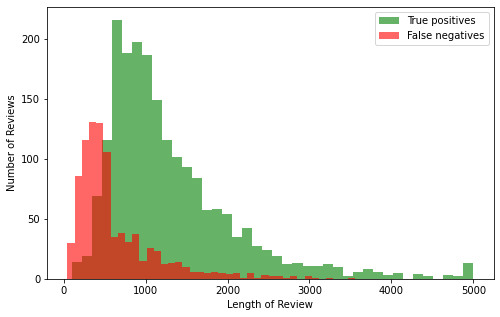

In [106]:
# Positive class analysis
fig, ax = plt.subplots(figsize=(8, 5));
ax.hist(TP.text_length, bins=40, color='g', alpha=0.6, label="True positives")
ax.hist(FN.text_length, bins=40, color='r', alpha=0.6, label="False negatives")
ax.set_xlabel("Length of Review")
ax.set_ylabel("Number of Reviews")
plt.legend()
plt.show()

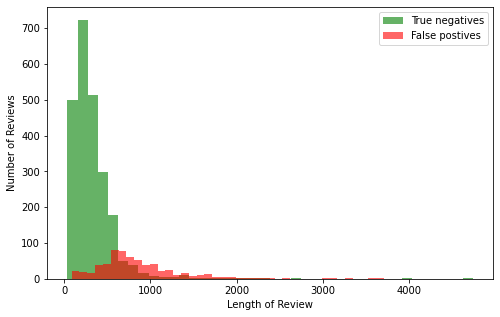

In [107]:
# Negative class analysis
fig, ax = plt.subplots(figsize=(8, 5));
ax.hist(TN.text_length, bins=40, color='g', alpha=0.6, label="True negatives")
ax.hist(FP.text_length, bins=40, color='r', alpha=0.6, label="False postives")
ax.set_xlabel("Length of Review")
ax.set_ylabel("Number of Reviews")
plt.legend()
plt.show()

## Trying best RoBERTa model with Bilal data

In [10]:
train_bilal = pd.read_csv("/content/drive/My Drive/Colab Notebooks/W266 Project/data/Paper_Data/train.csv", encoding='latin-1')
test_bilal = pd.read_csv("/content/drive/My Drive/Colab Notebooks/W266 Project/data/Paper_Data/test.csv", encoding='latin-1')
x_train_bilal = list(train_bilal[['sentence']].sentence)
y_train_bilal = np.asarray(train_bilal[['label']].label)

x_test_bilal = list(test_bilal[['sentence']].sentence)
y_test_bilal = np.asarray(test_bilal[['label']].label)

x_train_bilal, x_valid_bilal, y_train_bilal, y_valid_bilal = train_test_split(x_train_bilal, y_train_bilal, train_size=0.9)

In [13]:
max_lengths = [384]
for length in max_lengths:
  run_roberta(length, roberta_tokenizer, str.format('roberta_model_bilal_{length}', length = length), 
                                                    x_train = x_train_bilal,
                                                    y_train = y_train_bilal,
                                                    x_valid = x_valid_bilal,
                                                    y_valid = y_valid_bilal,
                                                    x_test = x_test_bilal,
                                                    y_test = y_test_bilal)

This model will be saved as roberta_model_bilal_384
Running roBERTa for encoding max_length: 384
Tokenizing data...
Created encoding for training data with shape (7200, 384)
Created encoding for validation data with shape (800, 384)
Created encoding for test data with shape (2000, 384)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


225/225 [==============================] - 141s 605ms/step - loss: 0.6754 - accuracy: 0.6044 - val_loss: 0.6657 - val_accuracy: 0.6787
Epoch 2/4
225/225 [==============================] - 134s 595ms/step - loss: 0.6565 - accuracy: 0.6597 - val_loss: 0.6535 - val_accuracy: 0.6812
Epoch 3/4
225/225 [==============================] - 134s 595ms/step - loss: 0.6486 - accuracy: 0.6704 - val_loss: 0.6430 - val_accuracy: 0.6875
Epoch 4/4
225/225 [==============================] - 134s 595ms/step - loss: 0.6399 - accuracy: 0.6765 - val_loss: 0.6372 - val_accuracy: 0.6913
Evaluating model...
63/63 [==============================] - 40s 572ms/step - loss: 0.6384 - accuracy: 0.6950
Test loss: 0.6383771896362305
Test accuracy: 0.6949999928474426
63/63 [==============================] - 38s 556ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.66      0.68      1000
           1       0.68      0.73      0.71      1000

    accura

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_bilal_384/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_bilal_384/assets


### Tryig Bilal data on RoBERTa model with linear decay learning rate

In [12]:
# Try it on our our previous best max_length of 384
max_lengths = [384]
# Best initial learning rate from Yelp data set
learning_rates = [3e-5]
for initial_learning_rate in learning_rates:
  warmup_schedule = create_learning_schedule(initial_learning_rate)
  for length in max_lengths:
    model_name = str.format('roberta_model_bilal_{length}_lr-{learning_rate}', length=length, learning_rate=initial_learning_rate)
    run_roberta(length, roberta_tokenizer, model_name, 
                                                    x_train = x_train_bilal,
                                                    y_train = y_train_bilal,
                                                    x_valid = x_valid_bilal,
                                                    y_valid = y_valid_bilal,
                                                    x_test = x_test_bilal,
                                                    y_test = y_test_bilal,
                                                    optimizer = tf.keras.optimizers.experimental.Adam(
      learning_rate = warmup_schedule))

This model will be saved as roberta_model_bilal_384_lr-3e-05
Running roBERTa for encoding max_length: 384
Tokenizing data...
Created encoding for training data with shape (7200, 384)
Created encoding for validation data with shape (800, 384)
Created encoding for test data with shape (2000, 384)
Using custom optimizer


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/4


225/225 [==============================] - 142s 594ms/step - loss: 0.6954 - accuracy: 0.5053 - val_loss: 0.6892 - val_accuracy: 0.6850
Epoch 2/4
225/225 [==============================] - 132s 586ms/step - loss: 0.6824 - accuracy: 0.5921 - val_loss: 0.6782 - val_accuracy: 0.6950
Epoch 3/4
225/225 [==============================] - 132s 586ms/step - loss: 0.6689 - accuracy: 0.6486 - val_loss: 0.6680 - val_accuracy: 0.6712
Epoch 4/4
225/225 [==============================] - 132s 586ms/step - loss: 0.6594 - accuracy: 0.6646 - val_loss: 0.6579 - val_accuracy: 0.6825
Evaluating model...
63/63 [==============================] - 34s 497ms/step - loss: 0.6598 - accuracy: 0.6705
Test loss: 0.6597793698310852
Test accuracy: 0.6704999804496765
63/63 [==============================] - 34s 492ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      1000
           1       0.71      0.57      0.63      1000

    accura

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_bilal_384_lr-3e-05/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/Project W266/roberta_model_bilal_384_lr-3e-05/assets
